# Import Libs

In [1]:
import os
import torch
import torch.optim as optim
from  torch import nn
from torchvision import transforms,models
from PIL import Image
from torch.utils.data import Dataset, DataLoader,Subset
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

d:\anaconda3\envs\computer_vision\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Prepare the Data

In [2]:
class LeafDiseaseDataset(Dataset):
    """
    
    """
    def __init__(self, root_dir ,transform=None,data_augmentation=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data_augmentation = data_augmentation
        self.samples = []
        self.labels = []

        self.leaf_type_map = {'Potato': 0, 'Tomato': 1, 'Pepper': 2}
        self.disease_type_map = {
            "Pepper__bell___Bacterial_spot":0,
            "Pepper__bell___healthy":1,
            "Potato___Early_blight":2,
            "Potato___healthy":3,
            "Potato___Late_blight":4,
            "Tomato__Target_Spot":5,
            "Tomato__Tomato_mosaic_virus":6,
            "Tomato__Tomato_YellowLeaf__Curl_Virus":7,
            "Tomato_Bacterial_spot":8,
            "Tomato_Early_blight":9,
            "Tomato_healthy":10,
            "Tomato_Late_blight":11,
            "Tomato_Leaf_Mold":12,
            "Tomato_Septoria_leaf_spot":13,
            "Tomato_Spider_mites_Two_spotted_spider_mite":14,

        }
        self.disease_classes = {
            'potato': 3,
            'tomato': 2,
            'pepper': 7
        }

        self._load_samples()

    def _load_samples(self):
        for folder_name in os.listdir(self.root_dir):
            folder_path = os.path.join(self.root_dir, folder_name)
            if os.path.isdir(folder_path):
                leaf_type, disease = folder_name.split('_')[0],folder_name
                leaf_label = self.leaf_type_map[leaf_type]
                disease_label = self.disease_type_map[disease]
                

                # Collect all image paths with labels
                for img_name in os.listdir(folder_path):
                    img_path = os.path.join(folder_path, img_name)
                    
                    # Skip files without extensions
                    if '.' not in img_name:
#                         os.remove(img_path)  # Remove the file
#                         print(f"Removed file without extension: {img_name}")
                        continue
                    self.samples.append((img_path, leaf_label, disease_label))
                    self.labels.append((leaf_label, disease_label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, leaf_label, disease_label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, (torch.tensor(leaf_label), torch.tensor(disease_label))


In [3]:
# image size
image_size = 256

# resize normalize transformations
resize_normalize = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# data augmentation transformations
data_augmentation = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.5)), # RandomZoom
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


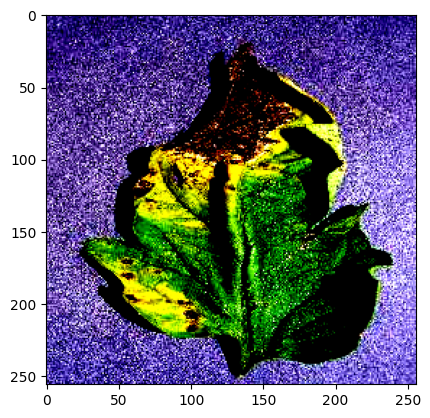

In [9]:
dataset = LeafDiseaseDataset(root_dir='./../PlantVillage', transform=resize_normalize)

labels = dataset.labels
train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.2, stratify=labels, random_state=42)

# Create subsets using the indices
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

# plot a simple without denormalizing the image
image,(label1,label2) = next(iter(train_dataset))
image = image.permute(1, 2, 0)
plt.imshow(image)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [10]:
"training Dataset length ===> "+str(len(train_dataset))

'training Dataset length ===> 16510'

### ploting same samples from the dataset

In [ ]:
# plt.figure(figsize=(12,12))
# for images, (label1,label2) in test_loader:
#     for i in range(12):
#         image = images[i].permute(1, 2, 0).numpy()

#         ax = plt.subplot(4,3,i+1)
#         mean = [0.485, 0.456, 0.406]  
#         std = [0.229, 0.224, 0.225]
#         image = image * std + mean
#         plt.imshow(image)
#         plt.title(f"Label:  {label1[i]}, {label2[i]}")  
#         plt.axis('off')
#     break

## Model Architecture

In [12]:
class MultiTaskLeafDiseaseClassifier(nn.Module):
    def __init__(self, num_leaf_classes=3, num_potato_disease_classes=3, 
                 num_tomato_disease_classes=10, num_pepper_disease_classes=2):
        super(MultiTaskLeafDiseaseClassifier, self).__init__()

        self.base_model = models.resnet50(pretrained=True)
        self.base_model.fc = nn.Identity()  # Remove the last layer

        # Leaf Type Classifier (Potato, Tomato, Pepper)
        self.leaf_classifier = nn.Linear(2048, num_leaf_classes)
        
        # Disease Classifiers
        self.disease_classifier = nn.Linear(2048, num_potato_disease_classes+num_pepper_disease_classes+num_tomato_disease_classes)

    def forward(self, x):

        features = self.base_model(x)
        
        # Leaf Classification
        leaf_type_output = self.leaf_classifier(features)

        # Disease Classification
        disease_output = self.disease_classifier(features)

        return leaf_type_output, disease_output

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# params
leraning_rate = 0.01
epochs = 50


In [12]:
import torch

torch.cuda.empty_cache()  # Libère la mémoire inutilisée
torch.cuda.memory_reserved(0)  # Réserve zéro si nécessaire


742391808

In [ ]:
!nvidia-smi

In [23]:
# Model
model = MultiTaskLeafDiseaseClassifier().to(device)

# loss functions
loss_leaf_fn = nn.CrossEntropyLoss()
loss_disease_fn = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(),lr=0.01)

# combined loss function
def combined_loss(leaf_preds, disease_preds, leaf_labels, disease_labels):
    # Leaf loss
    loss_leaf = loss_leaf_fn(leaf_preds, leaf_labels)
    
    # Disease loss    
    loss_disease = loss_disease_fn(disease_preds, disease_labels)

    return loss_leaf + loss_disease

# Training loop

for epoch in range(epochs):
    correct_leaf = 0
    correct_disease = 0
    lossT = 0

    total = 0

    
    pbar = tqdm(enumerate(train_loader), total=len(train_loader), 
                desc=f"Epoch {epoch + 1}/{epochs} - Leaf Acc: 0.00%, Disease Acc: 0.00%, Loss: 0.0000")
    for i,(images, (leaf_labels, disease_labels)) in pbar:
        leaf_labels = leaf_labels.to(device)
        disease_labels = disease_labels.to(device)
        images = images.to(device)
        # forward
        leaf_logits, disease_logits = model(images)
        
        # Compute loss
        loss = combined_loss(leaf_logits, disease_logits, leaf_labels, disease_labels)
        lossT+=loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # leaf prediction accuracy
        leaf_predictions = torch.argmax(leaf_logits, dim=1)
        correct_leaf += (leaf_predictions == leaf_labels).sum()

        # disease prediction accuracy

        disease_predictions = torch.argmax(disease_logits, dim=1)
        correct_disease += (disease_predictions == disease_labels).sum()


        total += leaf_labels.size(0)

        # Update tqdm description every 10 batches
        if (i + 1) % 10 == 0:
            pbar.set_description(
                f"Epoch {epoch + 1}/{epochs} - "
                f"Leaf Acc: {100 * correct_leaf / total:.2f}%, "
                f"Disease Acc: {100 * correct_disease / total:.2f}%, "
                f"Loss: {lossT / (i + 1):.4f}"
            )

# Final evaluation metrics
leaf_accuracy = 100 * correct_leaf / total
disease_accuracy = 100 * correct_disease / total
print(f"Epoch {epoch + 1} Completed - Leaf Accuracy: {leaf_accuracy:.2f}%, Disease Accuracy: {disease_accuracy:.2f}%")


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50 - Leaf Acc: 0.00%, Disease Acc: 0.00%, Loss: 0.0000:   0%|          | 0/258 [00:00<?, ?it/s]

Epoch 2/50 - Leaf Acc: 0.00%, Disease Acc: 0.00%, Loss: 0.0000:   0%|          | 0/258 [00:00<?, ?it/s]

Epoch 3/50 - Leaf Acc: 0.00%, Disease Acc: 0.00%, Loss: 0.0000:   0%|          | 0/258 [00:00<?, ?it/s]

Epoch 4/50 - Leaf Acc: 0.00%, Disease Acc: 0.00%, Loss: 0.0000:   0%|          | 0/258 [00:00<?, ?it/s]

Epoch 5/50 - Leaf Acc: 0.00%, Disease Acc: 0.00%, Loss: 0.0000:   0%|          | 0/258 [00:00<?, ?it/s]

Epoch 6/50 - Leaf Acc: 0.00%, Disease Acc: 0.00%, Loss: 0.0000:   0%|          | 0/258 [00:00<?, ?it/s]

Epoch 7/50 - Leaf Acc: 0.00%, Disease Acc: 0.00%, Loss: 0.0000:   0%|          | 0/258 [00:00<?, ?it/s]

Epoch 8/50 - Leaf Acc: 0.00%, Disease Acc: 0.00%, Loss: 0.0000:   0%|          | 0/258 [00:00<?, ?it/s]

Epoch 9/50 - Leaf Acc: 0.00%, Disease Acc: 0.00%, Loss: 0.0000:   0%|          | 0/258 [00:00<?, ?it/s]

Epoch 10/50 - Leaf Acc: 0.00%, Disease Acc: 0.00%, Loss: 0.0000:   0%|          | 0/258 [00:00<?, ?it/s]

Epoch 11/50 - Leaf Acc: 0.00%, Disease Acc: 0.00%, Loss: 0.0000:   0%|          | 0/258 [00:00<?, ?it/s]

Epoch 12/50 - Leaf Acc: 0.00%, Disease Acc: 0.00%, Loss: 0.0000:   0%|          | 0/258 [00:00<?, ?it/s]

Epoch 13/50 - Leaf Acc: 0.00%, Disease Acc: 0.00%, Loss: 0.0000:   0%|          | 0/258 [00:00<?, ?it/s]

Epoch 14/50 - Leaf Acc: 0.00%, Disease Acc: 0.00%, Loss: 0.0000:   0%|          | 0/258 [00:00<?, ?it/s]

Epoch 15/50 - Leaf Acc: 0.00%, Disease Acc: 0.00%, Loss: 0.0000:   0%|          | 0/258 [00:00<?, ?it/s]

Epoch 16/50 - Leaf Acc: 0.00%, Disease Acc: 0.00%, Loss: 0.0000:   0%|          | 0/258 [00:00<?, ?it/s]

Epoch 17/50 - Leaf Acc: 0.00%, Disease Acc: 0.00%, Loss: 0.0000:   0%|          | 0/258 [00:00<?, ?it/s]

Epoch 18/50 - Leaf Acc: 0.00%, Disease Acc: 0.00%, Loss: 0.0000:   0%|          | 0/258 [00:00<?, ?it/s]

Epoch 19/50 - Leaf Acc: 0.00%, Disease Acc: 0.00%, Loss: 0.0000:   0%|          | 0/258 [00:00<?, ?it/s]

Epoch 20/50 - Leaf Acc: 0.00%, Disease Acc: 0.00%, Loss: 0.0000:   0%|          | 0/258 [00:00<?, ?it/s]

Epoch 21/50 - Leaf Acc: 0.00%, Disease Acc: 0.00%, Loss: 0.0000:   0%|          | 0/258 [00:00<?, ?it/s]

Epoch 22/50 - Leaf Acc: 0.00%, Disease Acc: 0.00%, Loss: 0.0000:   0%|          | 0/258 [00:00<?, ?it/s]

Epoch 23/50 - Leaf Acc: 0.00%, Disease Acc: 0.00%, Loss: 0.0000:   0%|          | 0/258 [00:00<?, ?it/s]

Epoch 24/50 - Leaf Acc: 0.00%, Disease Acc: 0.00%, Loss: 0.0000:   0%|          | 0/258 [00:00<?, ?it/s]

Epoch 25/50 - Leaf Acc: 0.00%, Disease Acc: 0.00%, Loss: 0.0000:   0%|          | 0/258 [00:00<?, ?it/s]

Epoch 26/50 - Leaf Acc: 0.00%, Disease Acc: 0.00%, Loss: 0.0000:   0%|          | 0/258 [00:00<?, ?it/s]

Epoch 27/50 - Leaf Acc: 0.00%, Disease Acc: 0.00%, Loss: 0.0000:   0%|          | 0/258 [00:00<?, ?it/s]

Epoch 28/50 - Leaf Acc: 0.00%, Disease Acc: 0.00%, Loss: 0.0000:   0%|          | 0/258 [00:00<?, ?it/s]

Epoch 29/50 - Leaf Acc: 0.00%, Disease Acc: 0.00%, Loss: 0.0000:   0%|          | 0/258 [00:00<?, ?it/s]

Epoch 30/50 - Leaf Acc: 0.00%, Disease Acc: 0.00%, Loss: 0.0000:   0%|          | 0/258 [00:00<?, ?it/s]

Epoch 31/50 - Leaf Acc: 0.00%, Disease Acc: 0.00%, Loss: 0.0000:   0%|          | 0/258 [00:00<?, ?it/s]

Epoch 32/50 - Leaf Acc: 0.00%, Disease Acc: 0.00%, Loss: 0.0000:   0%|          | 0/258 [00:00<?, ?it/s]

Epoch 33/50 - Leaf Acc: 0.00%, Disease Acc: 0.00%, Loss: 0.0000:   0%|          | 0/258 [00:00<?, ?it/s]

Epoch 34/50 - Leaf Acc: 0.00%, Disease Acc: 0.00%, Loss: 0.0000:   0%|          | 0/258 [00:00<?, ?it/s]

Epoch 35/50 - Leaf Acc: 0.00%, Disease Acc: 0.00%, Loss: 0.0000:   0%|          | 0/258 [00:00<?, ?it/s]

Epoch 36/50 - Leaf Acc: 0.00%, Disease Acc: 0.00%, Loss: 0.0000:   0%|          | 0/258 [00:00<?, ?it/s]

Epoch 37/50 - Leaf Acc: 0.00%, Disease Acc: 0.00%, Loss: 0.0000:   0%|          | 0/258 [00:00<?, ?it/s]

Epoch 38/50 - Leaf Acc: 0.00%, Disease Acc: 0.00%, Loss: 0.0000:   0%|          | 0/258 [00:00<?, ?it/s]

Epoch 39/50 - Leaf Acc: 0.00%, Disease Acc: 0.00%, Loss: 0.0000:   0%|          | 0/258 [00:00<?, ?it/s]

Epoch 40/50 - Leaf Acc: 0.00%, Disease Acc: 0.00%, Loss: 0.0000:   0%|          | 0/258 [00:00<?, ?it/s]

Epoch 41/50 - Leaf Acc: 0.00%, Disease Acc: 0.00%, Loss: 0.0000:   0%|          | 0/258 [00:00<?, ?it/s]

Epoch 42/50 - Leaf Acc: 0.00%, Disease Acc: 0.00%, Loss: 0.0000:   0%|          | 0/258 [00:00<?, ?it/s]

Epoch 43/50 - Leaf Acc: 0.00%, Disease Acc: 0.00%, Loss: 0.0000:   0%|          | 0/258 [00:00<?, ?it/s]

Epoch 44/50 - Leaf Acc: 0.00%, Disease Acc: 0.00%, Loss: 0.0000:   0%|          | 0/258 [00:00<?, ?it/s]

Epoch 45/50 - Leaf Acc: 0.00%, Disease Acc: 0.00%, Loss: 0.0000:   0%|          | 0/258 [00:00<?, ?it/s]

Epoch 46/50 - Leaf Acc: 0.00%, Disease Acc: 0.00%, Loss: 0.0000:   0%|          | 0/258 [00:00<?, ?it/s]

Epoch 47/50 - Leaf Acc: 0.00%, Disease Acc: 0.00%, Loss: 0.0000:   0%|          | 0/258 [00:00<?, ?it/s]

Epoch 48/50 - Leaf Acc: 0.00%, Disease Acc: 0.00%, Loss: 0.0000:   0%|          | 0/258 [00:00<?, ?it/s]

Epoch 49/50 - Leaf Acc: 0.00%, Disease Acc: 0.00%, Loss: 0.0000:   0%|          | 0/258 [00:00<?, ?it/s]

Epoch 50/50 - Leaf Acc: 0.00%, Disease Acc: 0.00%, Loss: 0.0000:   0%|          | 0/258 [00:00<?, ?it/s]

Epoch 50 Completed - Leaf Accuracy: 99.93%, Disease Accuracy: 99.89%


In [ ]:
# test
model = MultiTaskLeafDiseaseClassifier()
model.load_state_dict(torch.load(".\\..\\app\\app\\models\\model-v1.pth", map_location=torch.device(device)))
print("testing with Test data ....")
with torch.no_grad():
    correct_leaf = 0
    correct_disease = 0

    total = 0

    
    pbar = tqdm(enumerate(test_loader), total=len(test_loader), 
                desc=f"Leaf Acc: 0.00%, Disease Acc: 0.00%")
    for i,(images, (leaf_labels, disease_labels)) in pbar:
        
        leaf_labels = leaf_labels.to(device)
        disease_labels = disease_labels.to(device)
        images = images.to(device)

        # forward
        leaf_logits, disease_logits = model(images)

        # leaf prediction accuracy
        leaf_predictions = torch.argmax(leaf_logits, dim=1)
        correct_leaf += (leaf_predictions == leaf_labels).sum()

        # disease prediction accuracy

        disease_predictions = torch.argmax(disease_logits, dim=1)
        correct_disease += (disease_predictions == disease_labels).sum()


        total += leaf_labels.size(0)

        # Update tqdm description every 10 batches
        if (i + 1) % 10 == 0:
            pbar.set_description(
                f"Leaf Acc: {100 * correct_leaf / total:.2f}%, "
                f"Disease Acc: {100 * correct_disease / total:.2f}%, "
            )

    # Final evaluation metrics
    leaf_accuracy = 100 * correct_leaf / total
    disease_accuracy = 100 * correct_disease / total
    print("Test data : ")
    print(f"Completed - Leaf Accuracy: {leaf_accuracy:.2f}%, Disease Accuracy: {disease_accuracy:.2f}%")



testing with Test data ....


Leaf Acc: 99.90%, Disease Acc: 99.43%, :  46%|████▌     | 30/65 [08:56<09:57, 17.08s/it]

: 

In [ ]:
from sklearn.metrics import classification_report

# Initialize metrics
all_leaf_labels = []
all_leaf_predictions = []
all_disease_labels = []
all_disease_predictions = []

print("Testing with Test data ....")
with torch.no_grad():
    correct_leaf = 0
    correct_disease = 0
    total = 0

    pbar = tqdm(enumerate(test_loader), total=len(test_loader), 
                desc=f"Leaf Acc: 0.00%, Disease Acc: 0.00%")
    for i, (images, (leaf_labels, disease_labels)) in pbar:
        leaf_labels = leaf_labels.to(device)
        disease_labels = disease_labels.to(device)
        images = images.to(device)

        # Forward pass
        leaf_logits, disease_logits = model(images)

        # Calculate predictions
        leaf_predictions = torch.argmax(leaf_logits, dim=1)
        disease_predictions = torch.argmax(disease_logits, dim=1)

        # Track accuracy
        correct_leaf += (leaf_predictions == leaf_labels).sum()
        correct_disease += (disease_predictions == disease_labels).sum()
        total += leaf_labels.size(0)

        # Collect predictions and labels for the classification report
        all_leaf_labels.extend(leaf_labels.cpu().numpy())
        all_leaf_predictions.extend(leaf_predictions.cpu().numpy())
        all_disease_labels.extend(disease_labels.cpu().numpy())
        all_disease_predictions.extend(disease_predictions.cpu().numpy())

        # Update tqdm description every 10 batches
        if (i + 1) % 10 == 0:
            pbar.set_description(
                f"Leaf Acc: {100 * correct_leaf / total:.2f}%, "
                f"Disease Acc: {100 * correct_disease / total:.2f}%, "
            )

    # Final metrics
    leaf_accuracy = 100 * correct_leaf / total
    disease_accuracy = 100 * correct_disease / total
    print("Test data : ")
    print(f"Completed - Leaf Accuracy: {leaf_accuracy:.2f}%, Disease Accuracy: {disease_accuracy:.2f}%")

# Classification report for both tasks
print("\nLeaf Classification Report:")
print(classification_report(all_leaf_labels, all_leaf_predictions, target_names=dataset.leaf_type_map.keys()))

print("\nDisease Classification Report:")
print(classification_report(all_disease_labels, all_disease_predictions, target_names=dataset.disease_type_map.keys()))


Testing with Test data ....


Leaf Acc: 0.00%, Disease Acc: 0.00%:   0%|          | 0/65 [00:00<?, ?it/s]

Test data : 
Completed - Leaf Accuracy: 99.54%, Disease Accuracy: 98.52%

Leaf Classification Report:
              precision    recall  f1-score   support

      Potato       0.97      0.98      0.98       430
      Tomato       1.00      1.00      1.00      3203
      Pepper       1.00      1.00      1.00       495

    accuracy                           1.00      4128
   macro avg       0.99      0.99      0.99      4128
weighted avg       1.00      1.00      1.00      4128


Disease Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.99      0.99      0.99       199
                     Pepper__bell___healthy       0.99      1.00      0.99       296
                      Potato___Early_blight       0.99      0.99      0.99       200
                           Potato___healthy       1.00      0.97      0.98        30
                       Potato___Late_blight       0.98     

In [28]:
torch.save(model.state_dict(), "/kaggle/working/model-v1.pth")